In [1]:
!pip install pretrainedmodels
!pip install pytorch-pretrained-bert
!pip install fastai

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

import gc
gc.collect()


%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai

from fastai import *
from fastai.vision import *
from fastai.text import *

from torchvision.models import *
import pretrainedmodels

import sys

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)


In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!ls "/content/drive/My Drive"

In [8]:
train_data=pd.read_csv('/content/drive/My Drive/jigsaw-toxic-comment-classification-challenge/train/train.csv')
test=pd.read_csv('/content/drive/My Drive/jigsaw-toxic-comment-classification-challenge/test/test_csv.csv', engine='python')
train, val = train_test_split(train_data, shuffle=True, test_size=0.1, random_state=42)

print(train.head())
print(train.shape,test.shape,val.shape)


                     id  ... identity_hate
34117  5b02208daa29a40f  ...             0
6579   1190ddc487465bd2  ...             0
59858  a0473abe447e04e3  ...             0
86152  e6763dac9d770096  ...             0
7620   1446437fe8605add  ...             0

[5 rows x 8 columns]
(143613, 8) (63978, 8) (15958, 8)


In [9]:
train.shape

(143613, 8)

In [10]:
train["others"]=np.where((train[['toxic', 'severe_toxic', 'obscene', 'threat',
                            'insult', 'identity_hate']].sum(axis=1))==0,1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
train.drop(train[train["others"]==1].index, inplace = True) 
train.drop("others", inplace = True,axis=1) 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
train.shape

(14650, 8)

In [0]:
test["others"]=np.where((test[['toxic', 'severe_toxic', 'obscene', 'threat',
                            'insult', 'identity_hate']].sum(axis=1))==0,1,0)

In [14]:
val["others"]=np.where((val[['toxic', 'severe_toxic', 'obscene', 'threat',
                            'insult', 'identity_hate']].sum(axis=1))==0,1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
test.drop(test[test["others"]==1].index, inplace = True) 
test.drop("others", inplace = True,axis=1) 

In [16]:
test.shape

(6243, 8)

In [17]:
val.drop(val[val["others"]==1].index, inplace = True)
val.drop("others", inplace = True,axis=1) 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
val.shape

(1575, 8)

In [0]:
train['comment_text']=[i.replace('\n','') for i in train['comment_text']]
train['comment_text']=[i.replace('\ ','') for i in train['comment_text']]
train['comment_text']=[i.strip() for i in train['comment_text']]

In [0]:
test['comment_text']=[i.replace('\n','') for i in test['comment_text']]
test['comment_text']=[i.replace('\ ','') for i in test['comment_text']]
test['comment_text']=[i.strip() for i in test['comment_text']]

In [0]:
val['comment_text']=[i.replace('\n','') for i in val['comment_text']]
val['comment_text']=[i.replace('\ ','') for i in val['comment_text']]
val['comment_text']=[i.strip() for i in val['comment_text']]

In [0]:
val['comment_text']=[i.replace('==','') for i in val['comment_text']]
val['comment_text']=[i.replace('::','') for i in val['comment_text']]
test['comment_text']=[i.replace('==','') for i in test['comment_text']]
test['comment_text']=[i.replace('::','') for i in test['comment_text']]
train['comment_text']=[i.replace('==','') for i in train['comment_text']]
train['comment_text']=[i.replace('::','') for i in train['comment_text']]

In [24]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
8,00091c35fa9d0465,"Arabs are committing genocide in Iraq, but no...",1,0,0,0,0,0
24,0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
29,0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
38,001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
40,001eff4007dbb65b,"No, he is an arrogant, self serving, immature ...",1,0,1,0,1,0


In [25]:
val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
25255,42d923c91158e044,"no worries We will use another account, and wi...",1,0,0,0,0,1
128796,b0c9e9304f37c9d3,Renzoy16 ! Shut The Fuck Up,1,0,1,0,1,0
99195,129afbc75eaad3b5,Suck my dikkkkk Suck my dikkkkk Gogo Gogo givi...,1,1,1,0,1,0
116391,6e30ac9f106693b0,please do not write me more!! Silly Perhaps no...,1,0,0,0,0,0
158055,e8075ef4262a156e,You're a jerk! You're a jerk!You're a jerk!You...,1,0,1,0,1,0


In [0]:
#train["comment_text"]=[i.strip() for i in train["comment_text"]]

In [0]:
#test["comment_text"]=[i.strip() for i in test["comment_text"]]

In [0]:
#val["comment_text"]=[i.strip() for i in val["comment_text"]]

In [26]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [0]:
train_new= train[['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']]

In [0]:
test_new= test[['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']]

In [0]:
val_new= val[['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']]

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=128), pre_rules=[], post_rules=[])


In [34]:
databunch = TextDataBunch.from_df(".", train_new, val_new,test_new,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols='comment_text',
                  label_cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'],
                  bs=16,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [35]:

databunch.show_batch()

text,target
"[CLS] "" _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ two years later _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ as ever , stupidity prevailed in this case , with user : re",toxic
"[CLS] "" are you fucking re ##tar ##ded ? tab ##ple ##ase do not del ##ete content from articles on wikipedia , as you did to solar ##is ( 2002 film ) . your edit ##s appear to be van ##dal ##ism and have been reverted . if you would like to experiment , please use wikipedia : sand ##box for test edit ##s . thank you . ali tab",toxic;obscene;insult
"[CLS] screw you ! ! ! you know something , you had me blocked before for something that you van ##dal ##ized , and so did that spit ##hole user : snow ##fire ##51 . you are a spit ##hole , and that is what you will always amount to be , forever ! go ahead , block me . block me forever and ever , but remember , you",toxic;obscene;insult
[CLS] freedom of speech ##i notice you removed my final speech . how sad . so what next ? remove this ? remove all of my edit ##s ? you have pont ##ific ##ated over my edit ##s in liverpool and now you accuse me of being an abuse ##r . your sp ##iel with kitchen knife [ thus i ' ve given him an ultimatum to change or be,toxic
[CLS] penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 = d ~ ~ penis 8 =,toxic;severe_toxic;obscene


In [0]:
databunch.save()

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

In [0]:
loss_func = nn.BCEWithLogitsLoss()
acc_50 = partial(accuracy_thresh, thresh=0.50)
model = bert_model_class

In [0]:
from fastai.callbacks import *

learner = Learner(
    databunch, model,
    loss_func=loss_func, model_dir='all_bert_model_50/', metrics=[acc_50,fbeta]
)


In [0]:
#learner.load('/content/drive/My Drive/account.h5')

In [0]:
import numpy as np

In [0]:
def bert_clas_split(self) -> List[nn.Module]:
    
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer)//3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

In [43]:
x = bert_clas_split(model)
learner.split([x[0],x[1],x[2],x[3],x[4]])

4


Learner(data=TextClasDataBunch;

Train: LabelList (14650 items)
x: TextList
[CLS] you seem to be van ##dal ##ising the article . why are you moving the reference to a stupid place ? [SEP],[CLS] the above poster sucks a lot of cock . [SEP],[CLS] it pains my heart to find out that wi ##ke ##ped ##ia evidently is mainly a male community with the usual sex ##ism that comes with the territory . i ' d say chin ##s , teeth and clothing are questions of taste . and as for any future wikipedia debates : i might bring up the argument that you ' re all male - cha ##u ##vin ##ist , sex ##ist big ##go ##ts ; ) [SEP],[CLS] " i had to put up with your shit to make two elementary enhancement ##s to the article , to add the well - known link between kant and bro ##uw ##er / hey ##ting , and to raise the concerns ( br ##uit ##ed not only by brand b ##lan ##sha ##rd but also by bertrand russell ) about philosophical style . the latter happens to be key to understanding kant because , as p . f . straw ##s

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 3.31E-01


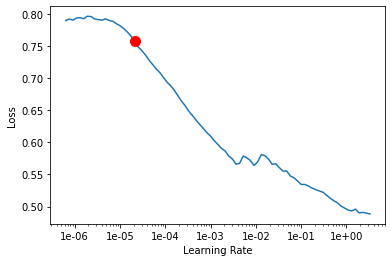

In [44]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [45]:
learner.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-8, 1e-7, 1e-5, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.271221,0.277048,0.889101,0.860241,04:09
1,0.249275,0.250493,0.892804,0.876837,04:15
2,0.221631,0.248708,0.895026,0.877840,03:28
3,0.170625,0.267492,0.891958,0.877675,04:09
4,0.138765,0.293009,0.890900,0.876197,04:24
5,0.115234,0.298961,0.887831,0.876251,04:17


In [46]:

learner.save('head')
learner.load('head')

Learner(data=TextClasDataBunch;

Train: LabelList (14650 items)
x: TextList
[CLS] you seem to be van ##dal ##ising the article . why are you moving the reference to a stupid place ? [SEP],[CLS] the above poster sucks a lot of cock . [SEP],[CLS] it pains my heart to find out that wi ##ke ##ped ##ia evidently is mainly a male community with the usual sex ##ism that comes with the territory . i ' d say chin ##s , teeth and clothing are questions of taste . and as for any future wikipedia debates : i might bring up the argument that you ' re all male - cha ##u ##vin ##ist , sex ##ist big ##go ##ts ; ) [SEP],[CLS] " i had to put up with your shit to make two elementary enhancement ##s to the article , to add the well - known link between kant and bro ##uw ##er / hey ##ting , and to raise the concerns ( br ##uit ##ed not only by brand b ##lan ##sha ##rd but also by bertrand russell ) about philosophical style . the latter happens to be key to understanding kant because , as p . f . straw ##s

In [39]:
learner.freeze_to(-2)
learner.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.395858,0.402614,0.782645,0.819255,02:52
1,0.403122,0.402289,0.782645,0.819255,02:46


In [40]:
learner.save('head-2')
learner.load('head-2')

Learner(data=TextClasDataBunch;

Train: LabelList (14650 items)
x: TextList
[CLS] you seem to be van ##dal ##ising the article . why are you moving the reference to a stupid place ? [SEP],[CLS] \ the above poster sucks a lot of cock . [SEP],[CLS] it pains my heart to find out that wi ##ke ##ped ##ia evidently is mainly a male community with the usual sex ##ism that comes with the territory . i ' d say chin ##s , teeth and clothing are questions of taste . and as for any future wikipedia debates : i might bring up the argument that you ' re all male - cha ##u ##vin ##ist , sex ##ist big ##go ##ts ; ) [SEP],[CLS] " i had to put up with your shit to make two elementary enhancement ##s to the article , to add the well - known link between kant and bro ##uw ##er / hey ##ting , and to raise the concerns ( br ##uit ##ed not only by brand b ##lan ##sha ##rd but also by bertrand russell ) about philosophical style . the latter happens to be key to understanding kant because , as p . f . straw #

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.00E-02


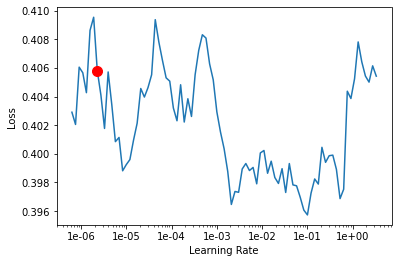

In [42]:

learner.lr_find()
learner.recorder.plot(suggestion=True)

In [43]:
learner.fit_one_cycle(6, slice(1e-6, 1e-5), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.407146,0.402289,0.782645,0.819255,05:07
1,0.401412,0.402289,0.782645,0.819255,04:40


In [44]:
learner.save('all')
learner.load('all')

Learner(data=TextClasDataBunch;

Train: LabelList (14650 items)
x: TextList
[CLS] you seem to be van ##dal ##ising the article . why are you moving the reference to a stupid place ? [SEP],[CLS] \ the above poster sucks a lot of cock . [SEP],[CLS] it pains my heart to find out that wi ##ke ##ped ##ia evidently is mainly a male community with the usual sex ##ism that comes with the territory . i ' d say chin ##s , teeth and clothing are questions of taste . and as for any future wikipedia debates : i might bring up the argument that you ' re all male - cha ##u ##vin ##ist , sex ##ist big ##go ##ts ; ) [SEP],[CLS] " i had to put up with your shit to make two elementary enhancement ##s to the article , to add the well - known link between kant and bro ##uw ##er / hey ##ting , and to raise the concerns ( br ##uit ##ed not only by brand b ##lan ##sha ##rd but also by bertrand russell ) about philosophical style . the latter happens to be key to understanding kant because , as p . f . straw #

In [49]:
text = test[0:1]['comment_text'].values
print(test_new[0:1])
print(text)
learner.predict(text)


                                        comment_text  ...  identity_hate
8   Arabs are committing genocide in Iraq, but no...  ...              0

[1 rows x 7 columns]
[' Arabs are committing genocide in Iraq, but no protests in Europe.   May Europe also burn in hell.']


(MultiCategory toxic;identity_hate,
 tensor([1., 0., 0., 0., 0., 1.]),
 tensor([0.9659, 0.0449, 0.0084, 0.2351, 0.0123, 0.5347]))

In [50]:
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
8,00091c35fa9d0465,"Arabs are committing genocide in Iraq, but no...",1,0,0,0,0,0
24,0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
29,0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
38,001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
40,001eff4007dbb65b,"No, he is an arrogant, self serving, immature ...",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
63877,ff91c3d8a3e34398,NIGEL IS A CRAZY IDIOT!!!,1,0,0,0,1,0
63935,ffd49b8defd069d0,""" Well, now don't I feel stupid.... · """,0,0,0,0,1,0
63945,ffdf6854b41d9102,Fourth Baldrick possibly being cleverer than i...,1,0,0,0,0,0
63962,ffebe90c8d5acaba,""" IRAN That’s right, Iran. It was our dron...",1,0,1,0,0,0


In [51]:
preds_labels=[]
df = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'])
for i in range(test.shape[0]):
  sent=test[i:i+1]['comment_text'].values
  print(sent) 
  a,b,c=learner.predict(sent)
  print(c)
  p=np.where(c.numpy() >= 0.7, 1, 0)
  print(p)
  #index=np.where(p == 1)
  labels=p.tolist()
  df1=pd.DataFrame([labels],columns=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'])
  #print(df1)
  df=pd.concat([df,df1],axis=0)
  #print(df)
  
  

df['comment_text']=test['comment_text']
df['id']=test['id']
#df['mot']=test['mot']
#df['predicted_mot']=preds_labels



Streaming output truncated to the last 5000 lines.
[1 0 0 0 0 0]
["Please get off my talk page or I will request a block interaction. I will discuss these edits on her talk page with you and other editors, but do not come in here if you're going to start this again. Everything for the past few days, has been fine - even with Simon who called me a bastard/idiot/stupid before. This is my first and last warning so I do not want to see a reply here."]
tensor([0.3933, 0.0044, 0.6515, 0.0116, 0.4794, 0.0026])
[0 0 0 0 0 0]
[' 5x5   is also a badybulders rutine, maybe some considoration for the healthy people u fukkkin nerd']
tensor([0.9932, 0.0680, 0.9888, 0.0032, 0.9674, 0.0124])
[1 0 1 0 1 0]
["I will dare to say only one thing: you are all here too hipocritics, incompetents, idiots, morons, neegers, suckers, mother-fuckers, father-fuckers, stupids and narrow minded to solve this problem that we have with this article from near an year. Every time I'm trying to start a discussion about fig

In [0]:
df.reset_index(inplace=True)

In [0]:
test.reset_index(inplace=True)

In [0]:
df['comment_text']=test['comment_text']
df['id']=test['id']

In [0]:
df.drop('index',axis=1,inplace=True)

In [0]:
df.columns

In [0]:
test

In [0]:
y_pred=df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
y_actual=test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()

In [0]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

In [0]:
fbeta_score(y_actual, y_pred, average='macro', beta=0.5)

In [0]:
#df.to_excel(('/content/drive/My Drive/emotions.xlsx'))